# preparo il dataset


In [1]:
# librerie
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import FakeManila, FakePerth # We can choose among many backends in 'fake_provider'
from qiskit import transpile
from qiskit.tools.visualization import plot_histogram
from qiskit import Aer
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

come prima cosa definisco il mio circuito

In [2]:
help(QuantumCircuit())

Help on QuantumCircuit in module qiskit.circuit.quantumcircuit object:

class QuantumCircuit(builtins.object)
 |  QuantumCircuit(*regs: 'Register | int | Sequence[Bit]', name: 'str | None' = None, global_phase: 'ParameterValueType' = 0, metadata: 'dict | None' = None)
 |  
 |  Create a new circuit.
 |  
 |  A circuit is a list of instructions bound to some registers.
 |  
 |  Args:
 |      regs (list(:class:`~.Register`) or list(``int``) or list(list(:class:`~.Bit`))): The
 |          registers to be included in the circuit.
 |  
 |          * If a list of :class:`~.Register` objects, represents the :class:`.QuantumRegister`
 |            and/or :class:`.ClassicalRegister` objects to include in the circuit.
 |  
 |            For example:
 |  
 |              * ``QuantumCircuit(QuantumRegister(4))``
 |              * ``QuantumCircuit(QuantumRegister(4), ClassicalRegister(3))``
 |              * ``QuantumCircuit(QuantumRegister(4, 'qr0'), QuantumRegister(2, 'qr1'))``
 |  
 |          * 

In [91]:
circuit = QuantumCircuit(5, 2)
reps = 3
for i in range(reps): #ripete 3 volte la seguenza di gates da te scelta
    circuit.h(0)
    circuit.rx(2/3*np.pi, 1)
    circuit.cx(0,1)
    circuit.ry(np.pi/3, 3)
    circuit.cx(2,3)
    circuit.h(3)
    circuit.cx(3,4)
    circuit.cx(0,2)
    circuit.cx(1,4)
    circuit.rx(2/7*np.pi, 4)
circuit.measure([4,3], [0, 1])
# circuit.measure_all()
print(circuit)

        ┌───┐              ┌───┐                           ┌───┐     »
q_0: ───┤ H ├──────■────■──┤ H ├───────────────────■────■──┤ H ├─────»
     ┌──┴───┴───┐┌─┴─┐  │  └───┘     ┌──────────┐┌─┴─┐  │  └───┘     »
q_1: ┤ Rx(2π/3) ├┤ X ├──┼─────────■──┤ Rx(2π/3) ├┤ X ├──┼─────────■──»
     └──────────┘└───┘┌─┴─┐       │  └──────────┘└───┘┌─┴─┐       │  »
q_2: ──────────────■──┤ X ├───────┼────────────────■──┤ X ├───────┼──»
     ┌─────────┐ ┌─┴─┐├───┤       │  ┌─────────┐ ┌─┴─┐├───┤       │  »
q_3: ┤ Ry(π/3) ├─┤ X ├┤ H ├──■────┼──┤ Ry(π/3) ├─┤ X ├┤ H ├──■────┼──»
     └─────────┘ └───┘└───┘┌─┴─┐┌─┴─┐├─────────┴┐└───┘└───┘┌─┴─┐┌─┴─┐»
q_4: ──────────────────────┤ X ├┤ X ├┤ Rx(2π/7) ├──────────┤ X ├┤ X ├»
                           └───┘└───┘└──────────┘          └───┘└───┘»
c: 2/════════════════════════════════════════════════════════════════»
                                                                     »
«                                                       
«q_0: ──────────────

la funzione trasnpile mi permette di costruire un circuito equivalente al mio leggibile dal computer quantistico che simulo perché ogni computer quantistico ha i suoi gate "nativi" e quindi devo trovare il modo di scrivere i miei gate con i suoi



faccio runnare il circuito, e costruisco il mio dataset

In [92]:
def run_circuit(circuit, backend, shots = 1000, measured_qubits = 5):
    transpiled_circuit = transpile(circuit, backend) 
    job = backend.run(transpiled_circuit, shots = shots)
    counts = job.result().get_counts()
    all_possible_keys = [format(i, '0'+str(measured_qubits)+'b') for i in range(2**measured_qubits)]
    for key in all_possible_keys:
        if key not in counts:
            counts[key] = 0.0
    sorted_counts = dict(sorted(counts.items()))
    return sorted_counts

def make_dataset(num_samples, circuit, backend1, backend2, shots = 1000, measured_qubits = 5):
    dataset = np.zeros((2*num_samples, 2**measured_qubits))
    for i in range(num_samples):
        counts_array = np.zeros(0)
        counts = run_circuit(circuit, backend1, shots, measured_qubits)
        for key in counts.keys():
            counts_array = np.append(counts_array, counts[key])
        dataset[i] = counts_array
    for i in range(num_samples, 2*num_samples):
        counts_array = np.zeros(0)
        counts = run_circuit(circuit, backend2, shots, measured_qubits)
        for key in counts.keys():
            counts_array = np.append(counts_array, counts[key])
        dataset[i] = counts_array
    labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples)])
    return dataset, labels

In [105]:
# In this example, the dataset will contain 1000 samplings, 500 ran with Manila and 500 ran with Perth
# Note that generating the dataset may take a while.
dataset, labels = make_dataset(500, circuit, FakeManila(), FakePerth(), shots = 100000, measured_qubits=2)
dataset.shape

(1000, 4)

In [106]:
np.save('dataset4f10', dataset)
np.save('labels4f10', labels)

In [107]:
import matplotlib.pyplot as plt

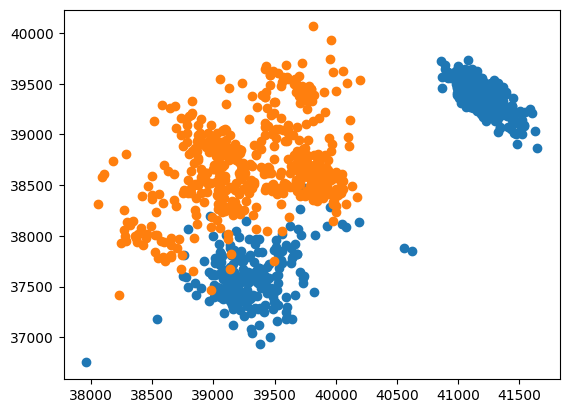

In [108]:
plt.scatter(x=dataset[labels==0,0], y=dataset[labels==0,1] )
plt.scatter(x=dataset[labels==1,0], y=dataset[labels==1,1] )

# Support Vector Machine classica


In [109]:
# Dataset loading
dataset = np.load('dataset4f6.npy')
labels = np.load('labels4f6.npy')

In [47]:
dataset.shape #solo per controllare che sia uguale a quello sopra

(1000, 4)

In [49]:
print(dataset[34,3])

562.0


In [50]:
# Dataset rescaling and training/validation split

scaler = MinMaxScaler().fit(dataset) #normalizzazione
dataset = scaler.transform(dataset)
training_set, validation_set, training_label, validation_label = train_test_split(dataset, labels, train_size = 0.7)

In [51]:
print(dataset[33,1]) #controlla la normalizzazione

0.8503401360544212


In [87]:
# SVM definition and training
svm_classifier = SVC(kernel='sigmoid', C=10, gamma=0.01, coef0=1)
svm_classifier.fit(training_set, training_label)

SVC(C=10, coef0=1, gamma=0.01, kernel='sigmoid')

In [83]:
from sklearn.model_selection import GridSearchCV 

In [84]:
#trovo i parametri migliori per il kernel
param_grid = {"C": [0.01, 0.1, 1, 10, 100, 1000, 10000], 
              "gamma": [0.01, 0.1, 1],
              "coef0": [0.01, 0.1, 1, 10]}
              #"degree":[1, 2, 3]}
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring="accuracy", verbose = 0)
grid_search.fit(training_set, training_label)
best_clf = grid_search.best_estimator_

In [85]:
print(best_clf)

SVC(C=10, coef0=1, gamma=0.01, kernel='sigmoid')


In [88]:
y_pred = svm_classifier.predict(validation_set)

# Evaluate the accuracy of the classifier

accuracy = accuracy_score(validation_label, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 67.67%


In [89]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
scores = cross_val_score(clf, dataset, labels, cv=5)
print(scores)
print(np.mean(scores))


[0.835 0.87  0.865 0.865 0.83 ]
0.8530000000000001
